# 3 Unsupervised Learning
Student ID: 35224436 | Full name: Yiming Zhang

## Question 3 Self-supervised Neural Network Learning

### Task I

#### Import Packages

In [265]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seed
np.random.seed(1)
torch.manual_seed(1)

#### Load Datasets

In [266]:
# Load datasets
# Task2C_labeled.csv - for training classifiers
labeled_data = pd.read_csv("Dataset_S2_2025/Task2C_labeled.csv")

# Task2C_unlabeled.csv - for training autoencoder (unlabeled data)
unlabeled_data = pd.read_csv("Dataset_S2_2025/Task2C_unlabeled.csv")

# Task2C_test.csv - for evaluating the trained classifier
test_data = pd.read_csv("Dataset_S2_2025/Task2C_test.csv")

# Display basic dataset information
print("===== Labeled Dataset (Task2C_labeled.csv) Information: =====")
print(f"Shape: {labeled_data.shape}")
print(f"Number of features: {labeled_data.shape[1] - 1} (pixel features)")
print(f"Number of samples: {labeled_data.shape[0]}")

print("\n===== Unlabeled Dataset (Task2C_unlabeled.csv) Information: =====")
print(f"Shape: {unlabeled_data.shape}")
print(f"Number of features: {unlabeled_data.shape[1]} (pixel features)")
print(f"Number of samples: {unlabeled_data.shape[0]}")

print("\n===== Test Dataset (Task2C_test.csv) Information: =====")
print(f"Shape: {test_data.shape}")
print(f"Number of features: {test_data.shape[1]} (pixel features)")
print(f"Number of samples: {test_data.shape[0]}")

===== Labeled Dataset (Task2C_labeled.csv) Information: =====
Shape: (50, 785)
Number of features: 784 (pixel features)
Number of samples: 50

===== Unlabeled Dataset (Task2C_unlabeled.csv) Information: =====
Shape: (1500, 784)
Number of features: 784 (pixel features)
Number of samples: 1500

===== Test Dataset (Task2C_test.csv) Information: =====
Shape: (500, 785)
Number of features: 785 (pixel features)
Number of samples: 500


### Task II

#### Data Preparation

In [267]:
# Prepare data for autoencoder training
# Combine labeled and unlabeled data (use only features, not labels)
# For labeled data, drop the 'label' column
X_labeled = labeled_data.drop('label', axis=1).values
X_unlabeled = unlabeled_data.values

# Combine both datasets for autoencoder training
X_autoencoder = np.vstack([X_labeled, X_unlabeled])

print(f"Combined data for autoencoder training:")
print(f"  - Labeled samples (features only): {X_labeled.shape}")
print(f"  - Unlabeled samples: {X_unlabeled.shape}")
print(f"  - Total samples for autoencoder: {X_autoencoder.shape}")
print(f"  - Number of input features: {X_autoencoder.shape[1]}")


Combined data for autoencoder training:
  - Labeled samples (features only): (50, 784)
  - Unlabeled samples: (1500, 784)
  - Total samples for autoencoder: (1550, 784)
  - Number of input features: 784


#### Helper Functions

In [268]:
# Define helper functions for autoencoder
def normalize(x, m=None, s=None):
    if m is None or s is None:
        # print('Normalizing data: No mean and/or sd given. Assuming it is training data')
        m, s = x.mean(), x.std()

    return (x - m) / s


def get_dataloader(X_train,Y_train=None, autoencoder=False,bs=128, standardize=True, return_dataset=False):
    """
    Retrieves a data loader to use for training. In case autoencoder=True, Y_train automatically is set to X_train
    The function returns the dataloader only if return_dataset is False otherwise it returns a tuple (dataloader,train_dataset)
    where train_dataset is the Dataset object after preprocessing.
    """
    try:
        X_train= np.array(X_train).astype(np.float32)
        if standardize: X_train = normalize(X_train)
        if not autoencoder: Y_train = np.array(Y_train)
    except Exception as e:
        raise Exception('Make sure your input and labels are array-likes. Your input failed with exception: %s'%e)
    # transform into tensors
    if autoencoder:
        Y_train = X_train
    
    X_train, Y_train = map(tensor, (X_train, Y_train))
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    X_train = X_train.to(device)
    Y_train = Y_train.to(device)
            
    train_ds = TensorDataset(X_train,Y_train)
    train_dl = DataLoader(train_ds, batch_size=16)
    
    if return_dataset: return train_dl,train_ds
    
    return train_dl



def train_autoencoder(X_train,hidden,activation='Tanh',epochs=10, trace=True, device="cpu", **kwargs):
    """
    Trains an Autoencoder and returns the trained model
    
    Params:
    X_train: Input data to train the autoencoder. Can be a dataframe, numpy, 2-D list or a tensor with 2 dimensions (batch_size, flattened_image_size)
    
    hidden: a list of sizes for the hidden layers ex: ([100,2,100]) will train an autoencoder with 3 layers
    
    activation (default='Tanh'): Activation type for hidden layers, output layer will always have a linear activation
    
    epochs: Number of epochs to train autoencoder
    
    trace: if true, will display epoch progress and will plot the loss plot at the end of training
    
    **kwargs: passed to Adam optimizer, lookup adam optimizer for more details
    """
    train_dl = get_dataloader(X_train,autoencoder=True)
    
    device = device
    
    # Building the autoencoder
    n_inps = [X_train.shape[-1]]
    n_out = n_inps
    layer_dims = n_inps + hidden + n_out
    layers = []
    try:
        non_linearity = getattr(nn,activation)()
    except AttributeError:
        raise Exception('Activation type not found, note that it is case senstive (ex: Tanh, Sigmoid,ReLU)')
        
    for i in range(len(layer_dims)-1):
        layers.extend([nn.Linear(layer_dims[i], layer_dims[i+1]), non_linearity])
    
    layers.pop()  # to remove the last non-linearity

    model = nn.Sequential(*layers)
    model = model.to(device)
    # print('Training Model on %s'%(device))
    # to capture training loss
    losses = []
    epoch_losses = []
    # define optimizer with learning rate
    optimizer = optim.Adam(model.parameters(), **kwargs)
    # we use MSE error for reconstruction loss
    loss_criterion = nn.MSELoss()
    # print the loss every 10% of epochs
    printing_step = int(epochs/5)
    # start training
    for epoch in range(epochs):
        for xb,yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb)
            loss = loss_criterion(preds,yb)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            model.zero_grad()
        # after epoch
        epoch_loss = np.mean(losses[-len(train_dl):]) # average loss across all batches
        epoch_losses.append(epoch_loss)
        if trace and not epoch%printing_step:
            print(f'Epoch {epoch}/{epochs} Loss:{epoch_loss}')

    return model, epoch_losses

#### Training Process

In [269]:
# Train autoencoders with different hidden layer sizes
hidden_sizes = list(range(20, 221, 40))  # [20, 60, 100, 140, 180, 220]

# Training parameters
epochs = 50
lr = 0.001
activation = "Tanh"

# Store models and losses
autoencoder_models = {}
autoencoder_losses = {}

# Train each autoencoder
for hidden_size in hidden_sizes:
    print(f"\n{'='*60}")
    print(f"Training autoencoder with {hidden_size} hidden neurons")
    model, losses = train_autoencoder(
        X_train=X_autoencoder,
        hidden=[hidden_size],
        activation=activation,
        epochs=epochs,
        lr=lr,
        trace=True,
    )

    autoencoder_models[hidden_size] = model
    autoencoder_losses[hidden_size] = losses

    print(f"{'='*60}")

print(f"\n{'='*60}")
print(f"Training completed for all autoencoders!")
print(f"{'='*60}")


Training autoencoder with 20 hidden neurons
Epoch 0/50 Loss:0.7917865520900058
Epoch 10/50 Loss:0.3489048806662412
Epoch 20/50 Loss:0.2853835791963892
Epoch 30/50 Loss:0.2747317067126638
Epoch 40/50 Loss:0.2598228141204598

Training autoencoder with 60 hidden neurons
Epoch 0/50 Loss:0.6389094634154409
Epoch 10/50 Loss:0.17091536491187578
Epoch 20/50 Loss:0.14539073161857644
Epoch 30/50 Loss:0.12396658434695804
Epoch 40/50 Loss:0.12411482808823437

Training autoencoder with 100 hidden neurons
Epoch 0/50 Loss:0.5573830171344206
Epoch 10/50 Loss:0.11791545928446288
Epoch 20/50 Loss:0.09146461758724193
Epoch 30/50 Loss:0.09183375114939876
Epoch 40/50 Loss:0.07840981979652778

Training autoencoder with 140 hidden neurons
Epoch 0/50 Loss:0.5073552998070864
Epoch 10/50 Loss:0.09215501073709469
Epoch 20/50 Loss:0.07188059347345657
Epoch 30/50 Loss:0.06279898265895155
Epoch 40/50 Loss:0.06037316486700294

Training autoencoder with 180 hidden neurons
Epoch 0/50 Loss:0.4698577600041616
Epoch 10/

#### Results Presentation

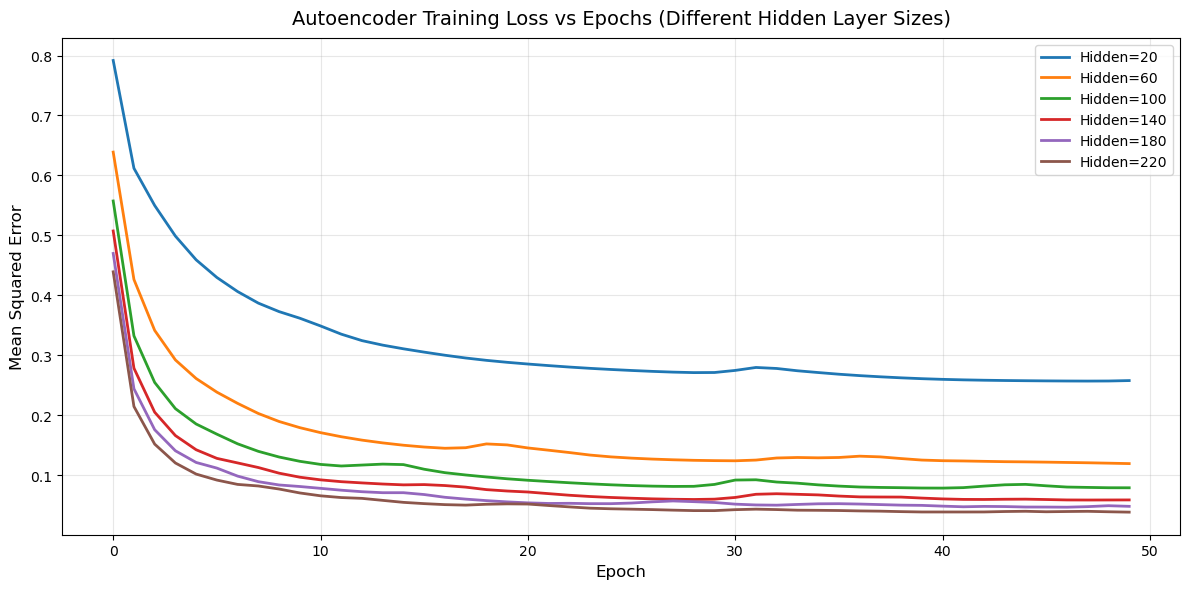


Final MSE Loss for each autoencoder:
----------------------------------------
20 neurons: 0.257776
60 neurons: 0.119277
100 neurons: 0.078920
140 neurons: 0.058673
180 neurons: 0.047978
220 neurons: 0.038297


In [270]:
# Visualize training losses for all autoencoders
plt.figure(figsize=(12, 6))

for hidden_size in hidden_sizes:
    losses = autoencoder_losses[hidden_size]
    plt.plot(range(len(losses)), losses, label=f'Hidden={hidden_size}', linewidth=2)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.title('Autoencoder Training Loss vs Epochs (Different Hidden Layer Sizes)', fontsize=14, pad=10)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display final losses
print("\nFinal MSE Loss for each autoencoder:")
print("-" * 40)
for hidden_size in hidden_sizes:
    final_loss = autoencoder_losses[hidden_size][-1]
    print(f"{hidden_size} neurons: {final_loss:.6f}")


### Task III

#### Calculate Reconstruction Error

In [271]:
def calculate_reconstruction_error(model, X_data):
    """
    Calculate the reconstruction error as the average Euclidean distance
    between input and output of the autoencoder
    """
    # Prepare data (normalize it the same way as during training)
    X_normalized = normalize(X_data.astype(np.float32))
    X_tensor = torch.tensor(X_normalized)

    # Get model predictions (reconstructions)
    model.eval()  # Set to evaluation mode
    with torch.no_grad():
        reconstructions = model(X_tensor)

    # Calculate Euclidean distance for each sample
    euclidean_distances = torch.sqrt(
        torch.sum((X_tensor - reconstructions) ** 2, dim=1)
    )

    # Calculate average reconstruction error
    avg_error = euclidean_distances.mean().item()

    return avg_error

In [272]:
# Calculate reconstruction error for each autoencoder model
reconstruction_errors = {}

print("=" * 60)

for hidden_size in hidden_sizes:
    model = autoencoder_models[hidden_size]
    error = calculate_reconstruction_error(model, X_autoencoder)
    reconstruction_errors[hidden_size] = error
    print(f"Hidden layer size {hidden_size} neurons, Reconstruction Error = {error:.4f}")

print("=" * 60)


Hidden layer size 20 neurons, Reconstruction Error = 14.0457
Hidden layer size 60 neurons, Reconstruction Error = 9.5801
Hidden layer size 100 neurons, Reconstruction Error = 7.8037
Hidden layer size 140 neurons, Reconstruction Error = 6.8767
Hidden layer size 180 neurons, Reconstruction Error = 6.1266
Hidden layer size 220 neurons, Reconstruction Error = 5.7185


#### Visualize Reconstruction Error vs Hidden Layer Size


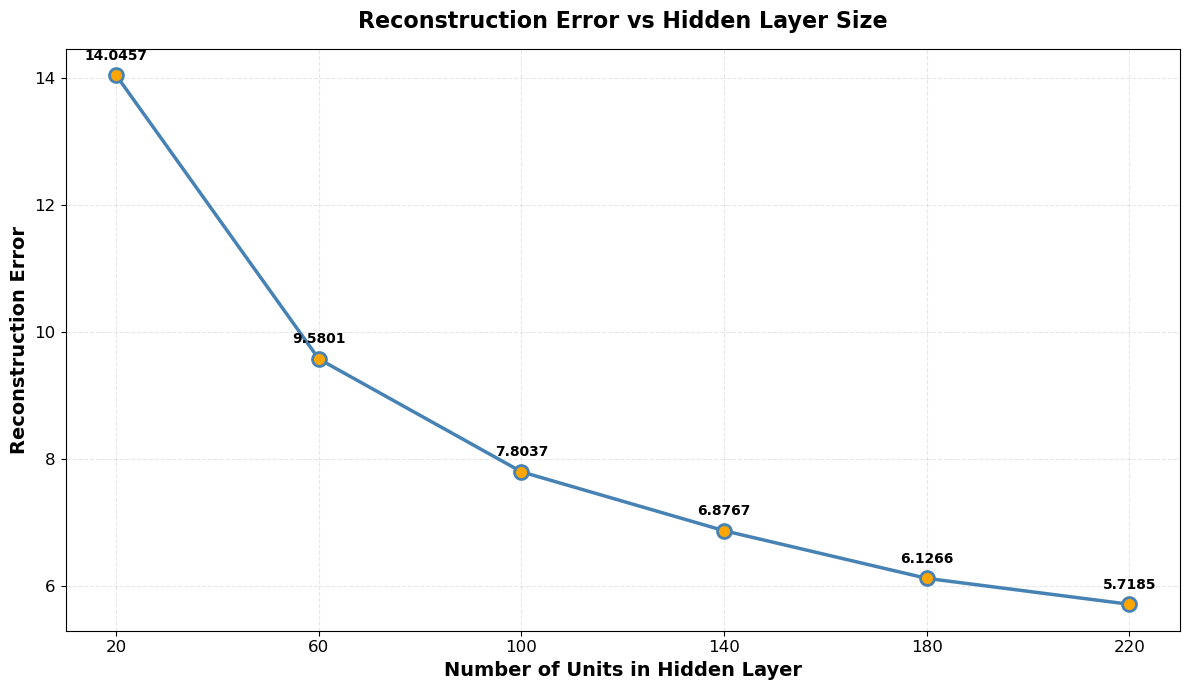

In [273]:
# Plot reconstruction error vs number of hidden neurons
plt.figure(figsize=(12, 7))

# Extract values for plotting
hidden_neurons = list(reconstruction_errors.keys())
errors = list(reconstruction_errors.values())

# Create line plot with markers
plt.plot(hidden_neurons, errors, marker='o', markersize=10, linewidth=2.5, 
         color='steelblue', markerfacecolor='orange', markeredgewidth=2, markeredgecolor='steelblue')

# Add value labels on each point
for i, (neurons, error) in enumerate(zip(hidden_neurons, errors)):
    plt.text(neurons, error + 0.2, f'{error:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Formatting
plt.xlabel('Number of Units in Hidden Layer', fontsize=14, fontweight='bold')
plt.ylabel('Reconstruction Error', fontsize=14, fontweight='bold')
plt.title('Reconstruction Error vs Hidden Layer Size', fontsize=16, fontweight='bold', pad=15)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(hidden_neurons, fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


#### Analysis and Findings

Based on the plot of reconstruction error vs. hidden layer size, we can observe the following key findings:

1. **Inverse Relationship**: There is a clear inverse relationship between the number of hidden neurons and the reconstruction error. As the number of hidden neurons increases, the reconstruction error decreases consistently.

2. **Diminishing Returns**: The rate of improvement (error reduction) follows a pattern of diminishing returns:
   - From 20 to 60 neurons: Large improvement in reconstruction error
   - From 60 to 100 neurons: Moderate improvement
   - From 100 to 220 neurons: Gradual but smaller improvements
   
3. **Capacity and Representation**:
   - **Smaller hidden layers (20 neurons)** create a significant bottleneck, forcing the autoencoder to learn a highly compressed representation. This results in higher reconstruction error as important information is lost in the compression.
   - **Larger hidden layers (220 neurons)** provide more capacity to capture the underlying patterns and structure in the data, resulting in better reconstruction quality.

4. **Trade-off Considerations**:
   - While larger hidden layers yield lower reconstruction error, they also require more computational resources and are more prone to overfitting, which may not generalize as well to unseen data
   - Smaller hidden layers provide better dimensionality reduction but at the cost of reconstruction quality


### Task IV

#### Prepare Training and Test Data for Classification

In [274]:
# Prepare training data from labeled dataset
# Extract features (all columns except 'label') and labels
X_train = labeled_data.drop('label', axis=1).values
y_train = labeled_data['label'].values

# Prepare test data
# Extract features and labels from test dataset
X_test = test_data.drop('label', axis=1).values
y_test = test_data['label'].values

# Display data information
print("Training Data for Classification:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  Number of classes: {len(np.unique(y_train))}")
print(f"  Class distribution in training: {np.bincount(y_train)}")

print("\nTest Data for Classification:")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")
print(f"  Number of classes: {len(np.unique(y_test))}")
print(f"  Class distribution in test: {np.bincount(y_test)}")


Training Data for Classification:
  X_train shape: (50, 784)
  y_train shape: (50,)
  Number of classes: 10
  Class distribution in training: [8 6 6 3 5 3 2 7 6 4]

Test Data for Classification:
  X_test shape: (500, 784)
  y_test shape: (500,)
  Number of classes: 10
  Class distribution in test: [51 48 54 49 54 43 59 47 38 57]


#### 3-Layer Neural Network Classifier Implementation

In [275]:
def train_classifier(X_train,Y_train,hidden,activation='Tanh',epochs=10, trace=True,device="cpu", **kwargs):
    """
    Trains a feedforward classifier and returns the trained model
    
    Params:
    X_train: Training data to train the autoencoder. Can be a dataframe, numpy, 2-D list or a tensor with 2 dimensions (batch_size, flattened_image_size)
    
    Y_train: Training labels. Can be a Series, 1D numpy array, 1-D list or a tensor with 1 dimension
    
    hidden: a list of sizes for the hidden layers ex: ([100,2,100]) will train an autoencoder with 3 layers
    
    activation (default='Tanh'): Activation type for hidden layers, output layer will always have a linear activation
    
    epochs: Number of epochs to train autoencoder
    
    trace: if true, will display epoch progress and will plot the loss plot at the end of training
    """
    train_dl = get_dataloader(X_train,Y_train,autoencoder=False)

    # Building the autoencoder
    n_inps = [X_train.shape[-1]]
    n_out = [np.unique(Y_train).shape[0]]   # is not a good idea if you are expecting very large datasets
    layer_dims = n_inps + hidden + n_out
    layers = []
    try:
        non_linearity = getattr(nn,activation)()
    except AttributeError:
        raise Exception('Activation type not found, note that it is case senstive (ex: Tanh, Sigmoid,ReLU)')
        
    for i in range(len(layer_dims)-1):
        layers.extend([nn.Linear(layer_dims[i], layer_dims[i+1]), non_linearity])
    
    layers.pop()  # to remove the last non-linearity

    model = nn.Sequential(*layers)
    model = model.to(device)
    # print('Training Model on %s'%(device))
    # to capture training loss
    losses = []
    epoch_losses =[]
    # define optimizer with learning rate
    optimizer = optim.Adam(model.parameters(),**kwargs)
    # we use MSE error for reconstruction loss
    loss_criterion = nn.CrossEntropyLoss()
    # calculate printing step - optional
    printing_step = int(epochs/5)
    # start training
    for epoch in range(epochs):
        for xb,yb in train_dl:
            xb
            preds = model(xb)
            loss = loss_criterion(preds,yb)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            model.zero_grad()
        # after epoch
        epoch_loss = np.mean(losses[-len(train_dl):]) # average loss across all batches
        epoch_losses.append(epoch_loss)
        if trace and not epoch%printing_step:
            print(f'Epoch {epoch}/{epochs}. Loss:{epoch_loss}')

    return model, epoch_losses


#### Helper Functions

In [276]:
def calculate_test_error(model, X_test, y_test):
    """
    Calculate test error and accuracy for a trained classifier
    """
    # Prepare test data (normalize using same approach as training)
    X_normalized = normalize(X_test.astype(np.float32))
    X_tensor = torch.tensor(X_normalized)

    # Move to same device as model
    device = next(model.parameters()).device
    X_tensor = X_tensor.to(device)

    # Set model to evaluation mode
    model.eval()

    # Make predictions without gradient computation
    with torch.no_grad():
        logits = model(X_tensor)
        # Get predicted class (index with highest probability)
        predictions = torch.argmax(logits, dim=1).cpu().numpy()

    # Calculate accuracy and error rate
    correct = (predictions == y_test).sum()
    total = len(y_test)
    accuracy = correct / total
    error_rate = 1 - accuracy

    return error_rate, accuracy, predictions

#### Train Classifiers with Different Hidden Layer Sizes

In [277]:
# Training parameters
classifier_epochs = 100
classifier_lr = 0.001
classifier_activation = "Tanh"

# Store classifier models, losses, and test errors
classifier_models = {}
classifier_losses = {}
test_errors = {}
test_accuracies = {}

# Train each classifier with different hidden layer sizes
for hidden_size in hidden_sizes:
    print(f"\n{'='*60}")
    print(f"Training classifier with {hidden_size} hidden neurons")

    # Train the classifier
    model, losses = train_classifier(
        X_train=X_train,
        Y_train=y_train,
        hidden=[hidden_size],
        activation=classifier_activation,
        epochs=classifier_epochs,
        lr=classifier_lr,
        trace=False,
    )

    # Calculate test error
    error_rate, accuracy, predictions = calculate_test_error(model, X_test, y_test)

    # Store results
    classifier_models[hidden_size] = model
    classifier_losses[hidden_size] = losses
    test_errors[hidden_size] = error_rate
    test_accuracies[hidden_size] = accuracy

    print(
        f"Final training loss: {losses[-1]:.6f}, Test accuracy: {accuracy:.4f}, Test error rate: {error_rate:.4f}"
    )
    print(f"{'='*60}")


print(f"\n{'='*60}")
print(f"Training completed for all classifiers!")
print(f"{'='*60}")


Training classifier with 20 hidden neurons
Final training loss: 0.053322, Test accuracy: 0.5860, Test error rate: 0.4140

Training classifier with 60 hidden neurons
Final training loss: 0.007162, Test accuracy: 0.6180, Test error rate: 0.3820

Training classifier with 100 hidden neurons
Final training loss: 0.003343, Test accuracy: 0.6300, Test error rate: 0.3700

Training classifier with 140 hidden neurons
Final training loss: 0.002169, Test accuracy: 0.6160, Test error rate: 0.3840

Training classifier with 180 hidden neurons
Final training loss: 0.001605, Test accuracy: 0.6240, Test error rate: 0.3760

Training classifier with 220 hidden neurons
Final training loss: 0.001330, Test accuracy: 0.6320, Test error rate: 0.3680

Training completed for all classifiers!


#### Results Presentation

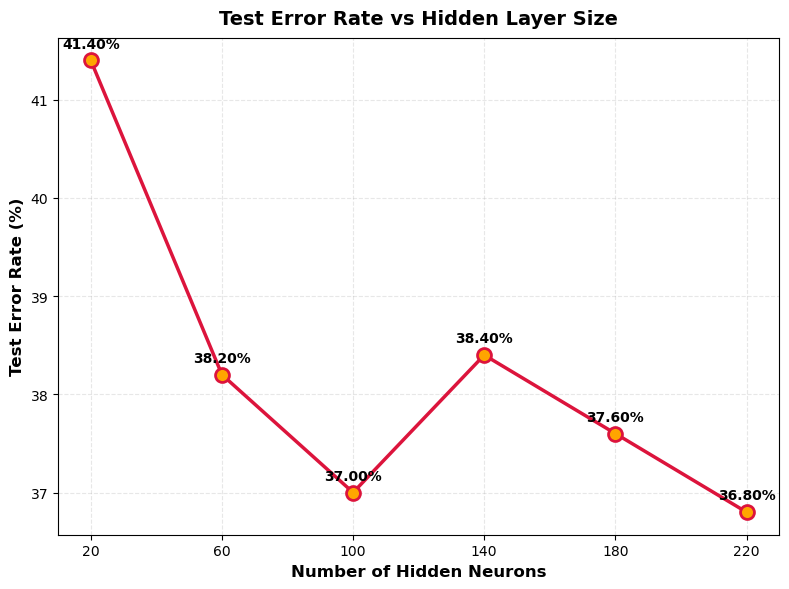

In [278]:
# Plot: Test Error Rate vs Hidden Layer Size
plt.figure(figsize=(8, 6))

hidden_neurons = list(test_errors.keys())
errors = [test_errors[h] * 100 for h in hidden_neurons]  # Convert to percentage

plt.plot(hidden_neurons, errors, marker='o', markersize=10, linewidth=2.5,
         color='crimson', markerfacecolor='orange', markeredgewidth=2, markeredgecolor='crimson')

# Add value labels on each point
for neurons, error in zip(hidden_neurons, errors):
    plt.text(neurons, error + 0.1, f'{error:.2f}%', ha='center', va='bottom', 
             fontsize=10, fontweight='bold')

plt.xlabel('Number of Hidden Neurons', fontsize=12, fontweight='bold')
plt.ylabel('Test Error Rate (%)', fontsize=12, fontweight='bold')
plt.title('Test Error Rate vs Hidden Layer Size', fontsize=14, fontweight='bold', pad=10)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(hidden_neurons)

plt.tight_layout()
plt.show()


In [279]:
best_hidden_size = min(test_errors, key=test_errors.get)
best_error = test_errors[best_hidden_size]
best_accuracy = test_accuracies[best_hidden_size]

print("=" * 60)
print(f"Best Model:")
print(f"Hidden layer size: {best_hidden_size} neurons")
print(f"Test error rate: {best_error:.4f} ({best_error*100:.2f}%)")
print("=" * 60)

Best Model:
Hidden layer size: 220 neurons
Test error rate: 0.3680 (36.80%)


### Task V

#### Extract Features from Autoencoder Hidden Layer

In [280]:
def extract_hidden_features(autoencoder_model, X_data):
    """
    Extract features from the hidden layer (middle layer) of the autoencoder
    """
    # Prepare data (normalize same as training)
    X_normalized = normalize(X_data.astype(np.float32))
    X_tensor = torch.tensor(X_normalized)

    # Move to same device as model
    device = next(autoencoder_model.parameters()).device
    X_tensor = X_tensor.to(device)

    # Set model to evaluation mode
    autoencoder_model.eval()

    # Extract hidden layer features 
    # layer 0: linear, layer 1: tanh, layer 2: linear (decoder)
    # We want the output after the first activation (layer 1)
    with torch.no_grad():
        # Pass through encoder layers only (first Linear + Activation)
        hidden = autoencoder_model[0](X_tensor)  # First linear layer
        hidden = autoencoder_model[1](hidden)  # Activation function

    # Convert to numpy array
    hidden_features = hidden.cpu().numpy()

    return hidden_features # numpy array

#### Create Augmented Feature Sets

In [281]:
augmented_train_features = {}
augmented_test_features = {}

for hidden_size in hidden_sizes:
    # Get the trained autoencoder model
    autoencoder = autoencoder_models[hidden_size]

    # Extract hidden features for training data
    train_hidden = extract_hidden_features(autoencoder, X_train)

    # Extract hidden features for test data
    test_hidden = extract_hidden_features(autoencoder, X_test)

    # Combine original features with hidden features
    X_train_augmented = np.hstack([X_train, train_hidden])
    X_test_augmented = np.hstack([X_test, test_hidden])

    # Store augmented features
    augmented_train_features[hidden_size] = X_train_augmented
    augmented_test_features[hidden_size] = X_test_augmented

    print("=" * 60)
    print(f"Hidden size {hidden_size}:")
    print(f"Original features: {X_train.shape[1]}")
    print(f"Extra features from autoencoder: {train_hidden.shape[1]}")
    print(f"Total augmented features: {X_train_augmented.shape[1]}")
    print(f"Training set shape: {X_train_augmented.shape}")
    print(f"Test set shape: {X_test_augmented.shape}")
    print("=" * 60)

Hidden size 20:
Original features: 784
Extra features from autoencoder: 20
Total augmented features: 804
Training set shape: (50, 804)
Test set shape: (500, 804)
Hidden size 60:
Original features: 784
Extra features from autoencoder: 60
Total augmented features: 844
Training set shape: (50, 844)
Test set shape: (500, 844)
Hidden size 100:
Original features: 784
Extra features from autoencoder: 100
Total augmented features: 884
Training set shape: (50, 884)
Test set shape: (500, 884)
Hidden size 140:
Original features: 784
Extra features from autoencoder: 140
Total augmented features: 924
Training set shape: (50, 924)
Test set shape: (500, 924)
Hidden size 180:
Original features: 784
Extra features from autoencoder: 180
Total augmented features: 964
Training set shape: (50, 964)
Test set shape: (500, 964)
Hidden size 220:
Original features: 784
Extra features from autoencoder: 220
Total augmented features: 1004
Training set shape: (50, 1004)
Test set shape: (500, 1004)


#### Train Augmented Self-Taught Networks

In [282]:
# Train augmented self-taught networks
print(f"Training Augmented Self-Taught Networks...\n")

# Training parameters
augmented_epochs = 100
augmented_lr = 0.001
augmented_activation = "Tanh"

# Store augmented models and results
augmented_models = {}
augmented_losses = {}
augmented_test_errors = {}
augmented_test_accuracies = {}

# Train each augmented model
for hidden_size in hidden_sizes:
    print(f"{'='*60}")
    print(f"Model: {hidden_size} hidden neurons + {hidden_size} extra features")

    # Get augmented training and test data
    X_train_aug = augmented_train_features[hidden_size]
    X_test_aug = augmented_test_features[hidden_size]

    # print(f"Training with {X_train_aug.shape[1]} total features")

    # Train the augmented classifier
    model, losses = train_classifier(
        X_train=X_train_aug,
        Y_train=y_train,
        hidden=[hidden_size],
        activation=augmented_activation,
        epochs=augmented_epochs,
        lr=augmented_lr,
        trace=False,
    )

    # Calculate test error on augmented test data
    error_rate, accuracy, predictions = calculate_test_error(model, X_test_aug, y_test)

    # Store results
    augmented_models[hidden_size] = model
    augmented_losses[hidden_size] = losses
    augmented_test_errors[hidden_size] = error_rate
    augmented_test_accuracies[hidden_size] = accuracy

    print(
        f"Final training loss: {losses[-1]:.6f}, Test accuracy: {accuracy:.4f}, Test error rate: {error_rate:.4f}"
    )
    print(f"{'='*60}")

Training Augmented Self-Taught Networks...

Model: 20 hidden neurons + 20 extra features
Final training loss: 0.055654, Test accuracy: 0.5860, Test error rate: 0.4140
Model: 60 hidden neurons + 60 extra features
Final training loss: 0.007022, Test accuracy: 0.6260, Test error rate: 0.3740
Model: 100 hidden neurons + 100 extra features
Final training loss: 0.003302, Test accuracy: 0.6240, Test error rate: 0.3760
Model: 140 hidden neurons + 140 extra features
Final training loss: 0.002100, Test accuracy: 0.6400, Test error rate: 0.3600
Model: 180 hidden neurons + 180 extra features
Final training loss: 0.001565, Test accuracy: 0.6420, Test error rate: 0.3580
Model: 220 hidden neurons + 220 extra features
Final training loss: 0.001281, Test accuracy: 0.6420, Test error rate: 0.3580


### Task VI

#### Classification Error Comparison Plot

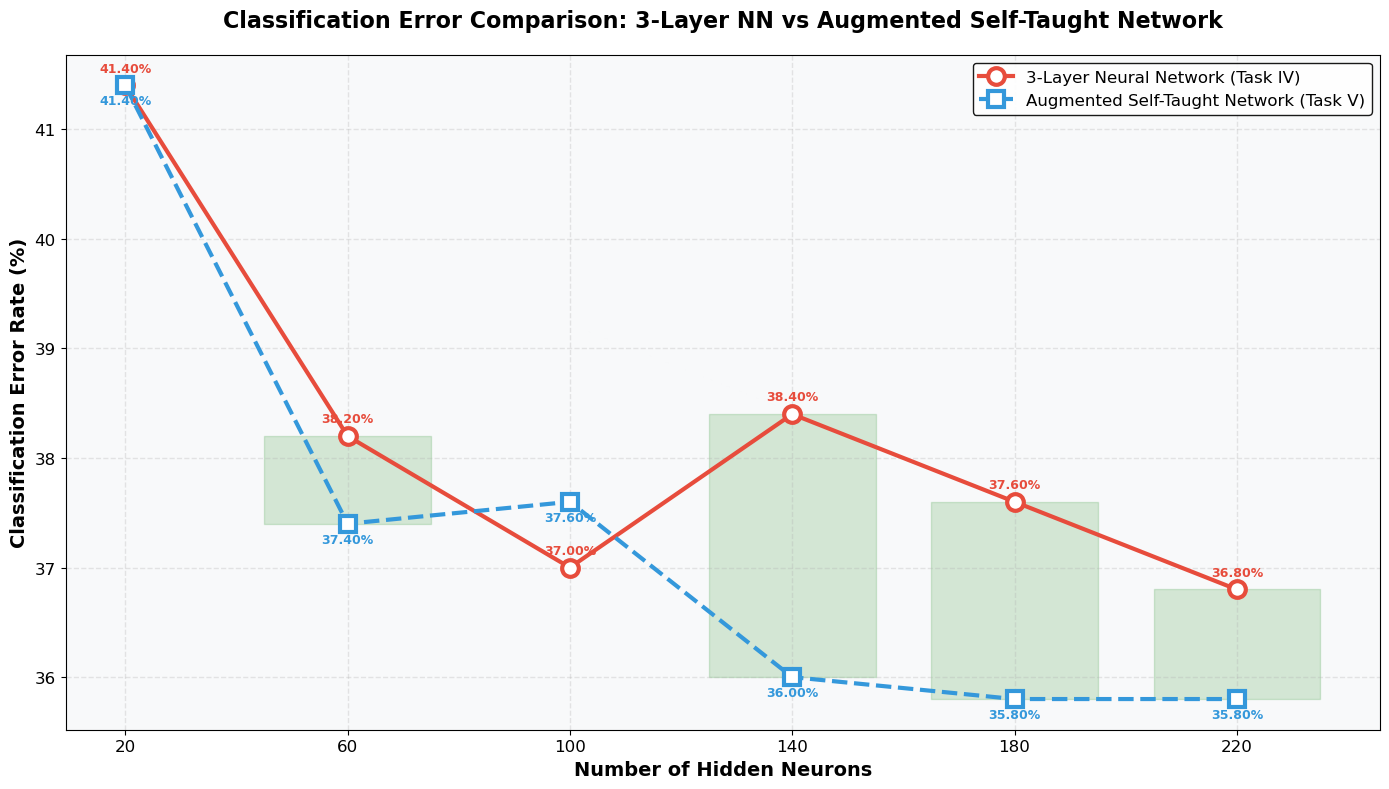


DETAILED ERROR RATE COMPARISON
Hidden Neurons       3-Layer NN Error     Augment NN Error     Difference          
--------------------------------------------------------------------------------
20                     41.40%               41.40%                  0.00% (same)  
60                     38.20%               37.40%                 +0.80% (better)
100                    37.00%               37.60%                 -0.60% (worse) 
140                    38.40%               36.00%                 +2.40% (better)
180                    37.60%               35.80%                 +1.80% (better)
220                    36.80%               35.80%                 +1.00% (better)


In [288]:
# Create the main comparison plot for Task VI
# X-axis: Number of hidden neurons
# Y-axis: Classification error rate

plt.figure(figsize=(14, 8))

# Extract data for plotting
hidden_neurons = list(hidden_sizes)
task_iv_errors = [test_errors[h] * 100 for h in hidden_neurons]  # Convert to percentage
task_v_errors = [augmented_test_errors[h] * 100 for h in hidden_neurons]  # Convert to percentage

# Plot both models
plt.plot(hidden_neurons, task_iv_errors, 
         marker='o', markersize=12, linewidth=3, 
         color='#e74c3c', markerfacecolor='#fff', markeredgewidth=3, markeredgecolor='#e74c3c',
         label='3-Layer Neural Network (Task IV)', linestyle='-')

plt.plot(hidden_neurons, task_v_errors, 
         marker='s', markersize=12, linewidth=3,
         color='#3498db', markerfacecolor='#fff', markeredgewidth=3, markeredgecolor='#3498db',
         label='Augmented Self-Taught Network (Task V)', linestyle='--')

# Add value labels on each point
for i, (neurons, error_iv, error_v) in enumerate(zip(hidden_neurons, task_iv_errors, task_v_errors)):
    # Task IV labels
    plt.text(neurons, error_iv + 0.1, f'{error_iv:.2f}%', 
             ha='center', va='bottom', fontsize=9, fontweight='bold', color='#e74c3c')
    # Task V labels
    plt.text(neurons, error_v - 0.2, f'{error_v:.2f}%', 
             ha='center', va='bottom', fontsize=9, fontweight='bold', color='#3498db')

# Formatting
plt.xlabel('Number of Hidden Neurons', fontsize=14, fontweight='bold')
plt.ylabel('Classification Error Rate (%)', fontsize=14, fontweight='bold')
plt.title('Classification Error Comparison: 3-Layer NN vs Augmented Self-Taught Network', 
          fontsize=16, fontweight='bold', pad=20)
plt.legend(fontsize=12, loc='upper right', framealpha=0.9, edgecolor='black')
plt.grid(True, alpha=0.3, linestyle='--', linewidth=1)
plt.xticks(hidden_neurons, fontsize=12)
plt.yticks(fontsize=12)

# Add background color
ax = plt.gca()
ax.set_facecolor('#f8f9fa')

# Add a shaded region to show improvement area
for i in range(len(hidden_neurons)):
    if task_iv_errors[i] > task_v_errors[i]:
        plt.fill_between([hidden_neurons[i]-15, hidden_neurons[i]+15], 
                         task_v_errors[i], task_iv_errors[i], 
                         alpha=0.15, color='green')

plt.tight_layout()
plt.show()

# Print numerical comparison
print("\n" + "="*80)
print("DETAILED ERROR RATE COMPARISON")
print("="*80)
print(f"{'Hidden Neurons':<20} {'3-Layer NN Error':<20} {'Augment NN Error':<20} {'Difference':<20}")
print("-"*80)
for neurons in hidden_neurons:
    iv_error = test_errors[neurons] * 100
    v_error = augmented_test_errors[neurons] * 100
    diff = iv_error - v_error
    diff_str = f"{diff:+.2f}%" if diff != 0 else "0.00%"
    print(f"{neurons:<20} {iv_error:>7.2f}%{' '*12} {v_error:>7.2f}%{' '*12} {diff_str:>10} {'(better)' if diff > 0 else '(worse)' if diff < 0 else '(same)':<8}")
print("="*80)


#### Explanation and Analysis

From the plot, both the **3-layer NN** and the **Augmented Self-Taught Network** show the same general trend — as the number of hidden neurons increases, the classification error goes down. This makes sense since a larger hidden layer gives the model more capacity to learn complex patterns in the data.

At smaller hidden sizes (20–100 neurons), both models perform similarly, with only small differences that could be due to randomness. But starting from 140 neurons, the **Augmented Self-Taught Network** consistently achieves lower error rates, for example 36.0% vs. 38.4% at 140 neurons and 35.8% vs. 37.6% at 180 neurons. This suggests that the benefit of using the extra features from the autoencoder becomes more apparent when the model has enough capacity to utilize them effectively.

The main reason behind this improvement is that the **self-taught model** combines supervised and unsupervised learning. The features extracted by the autoencoder capture important structure from both labeled and unlabeled data, giving the neural network richer inputs to work with. When the hidden layer is small, the network doesn’t have enough capacity to fully leverage these extra features, so the difference is minimal. As the network grows, it can make better use of these additional representations, which leads to consistently lower error rates.

Overall, the **augmented self-taught network** often performs better than a plain neural network, especially when labeled data are limited or the model capacity is small, but it is not guaranteed to always outperform it. Its advantage depends on the quality of the learned representations and how relevant they are to the target task
